# U3 L1 P4 - Model Comparison

### Emile Badran

Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.options.display.float_format = '{:,.5f}'.format

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

import statsmodels.formula.api as smf

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load and clean the data set and drop unnecessary columns

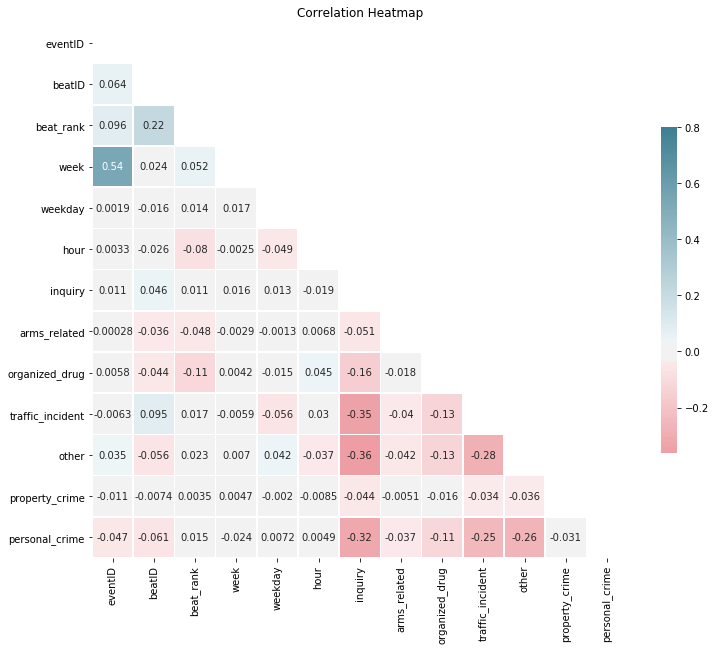

In [2]:
df = pd.read_csv('pmsc_features.csv')
df.date = pd.to_datetime(df.date)
df.set_index('date',inplace=True)
df = df.sort_index()

# Create a correlation heatmap
# Generate a mask for the upper triangle
mask = np.zeros_like(df.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df.corr(),
            mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [3]:
# Drop unnecessary columns, or uncorrelated columns:
df = df.drop(columns=['eventID','beatID','event_type','event_cat',
                      'hour','weekday','week','property_crime'])
df.head()

,beat_rank,inquiry,arms_related,organized_drug,traffic_incident,other,personal_crime
date,,,,,,,
2017-01-01 00:12:33,0.99275,1,0,0,0,0,0
2017-01-01 00:40:47,0.95652,0,0,0,0,0,1
2017-01-01 00:42:29,0.97101,0,0,0,0,0,1
2017-01-01 00:54:28,0.99275,0,0,0,0,0,1
2017-01-01 00:56:03,0.86957,0,0,0,0,0,1


#### Crime type descriptions:
- beat_rank - the percent rank of each beatID according to its frequency (beatIDs that have more crime events have higher ranks)
- violent_crime - Homicide, Rape and Sexual Assault, Robbery, Assault, Stalking/intimidation
- property_crime - Burglary, Larceny/theft, Motor vehicle theft, Purse snatching, and Pocket picking
- organized_drug - Organized or drug-related crime, including possesion, use, sales, and trafficking
- traffic_incident - Traffic-related incidents
- inquiry - Stops-and-frisks, arrest warrants, investigations, and other policing activities
- other - Misdemeanors and other crimes
- arms_related - Arms-related offenses

# Predict personal crime with linear regression
### Generate the PCA component and create train and test data sets

In [4]:
sklearn_pca = PCA(n_components=2)

x_pca = sklearn_pca.fit_transform(df[['beat_rank','inquiry','arms_related',
                                'organized_drug','traffic_incident','other']])
                                      
print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [ 0.43855402  0.35279796]


In [5]:
# Convert the above PCA with two components into a single component 
# with +80% of the total variance:
sklearn_pca = PCA(n_components=1)
x1_pca = sklearn_pca.fit_transform(x_pca)

# Add the single PCA component to the dataFrame and create train and test data:
df['pca'] = x1_pca
df_train = df.sample(n=int(len(df)*.6))
df_test = df.sample(n=int(len(df)*.4))

### Fit the linear formula using train data

In [6]:
# Fit the StatsModels linear regression:
linear_formula = 'personal_crime ~ pca'

# Fit the model to the train data:
lm = smf.ols(formula=linear_formula, data=df_train).fit()

# Inspect the train results:
print(lm.params)
print('\np-values:')
print(lm.pvalues)
print('\nr-squared:')
print(lm.rsquared)

Intercept    0.18503
pca         -0.06143
dtype: float64

p-values:
Intercept   0.00000
pca         0.00000
dtype: float64

r-squared:
0.00691844087785


### Cross validate with the test data set

In [7]:
# Create a variable with the sample size for each 10-fold iteration:
end = int(len(df)/10)

for i in range(10):   

    # Predict with the test sample WITHOUT THE TARGET COLUMN:
    y_pred = lm.predict(exog=df_test.pca.iloc[:end])
    target = df_test.personal_crime[:end]
    
    # Convert predictions to 0 or 1 based on a threshold:
    y_pred = y_pred.apply(lambda x: 1 if x>0.16 else 0)

    # Since the prediction is binary, it is useless to visualize residual values 
    # with a scatterplot. Instead, print p-values, r-squared and confusion matrix:
    print('\nROUND',i, '- sample size:', len(target))
    print(lm.params)
    print('\np-values:')
    print(lm.pvalues)
    print('\nr-squared:')
    print(lm.rsquared)
    print('\nconfusion mat:')
    print(confusion_matrix(target, y_pred))
    print('\n--------------------')
    
    # Increase sample size by 10%:
    end = end+(int(len(df)/10))


ROUND 0 - sample size: 4246
Intercept    0.18503
pca         -0.06143
dtype: float64

p-values:
Intercept   0.00000
pca         0.00000
dtype: float64

r-squared:
0.00691844087785

confusion mat:
[[1288 2130]
 [   0  828]]

--------------------

ROUND 1 - sample size: 8492
Intercept    0.18503
pca         -0.06143
dtype: float64

p-values:
Intercept   0.00000
pca         0.00000
dtype: float64

r-squared:
0.00691844087785

confusion mat:
[[2616 4271]
 [   0 1605]]

--------------------

ROUND 2 - sample size: 12738
Intercept    0.18503
pca         -0.06143
dtype: float64

p-values:
Intercept   0.00000
pca         0.00000
dtype: float64

r-squared:
0.00691844087785

confusion mat:
[[3975 6331]
 [   0 2432]]

--------------------

ROUND 3 - sample size: 16984
Intercept    0.18503
pca         -0.06143
dtype: float64

p-values:
Intercept   0.00000
pca         0.00000
dtype: float64

r-squared:
0.00691844087785

confusion mat:
[[5266 8509]
 [   0 3209]]

--------------------

ROUND 4 - sam

## Predict personal crime with KNN:

In [8]:
# Build our model.
knn = neighbors.KNeighborsClassifier(n_neighbors=10)

# Fit the model with TRAIN data:
estimator = knn.fit(df_train.pca.reshape(-1,1), df_train.personal_crime.reshape(-1,1))

# Test the model with TEST data excluding personal crime:
prediction = knn.predict(df_test.pca.reshape(-1,1))

df_test['prediction'] = prediction

print('clockwise - TN, FP, TP, FN')
confusion_matrix(df_test.personal_crime, df_test.prediction)

clockwise - TN, FP, TP, FN


array([[13702,    74],
       [    0,  3210]])

In [9]:
# Cross-validate the Knn regression:
scores = cross_val_score(estimator, df_test.pca.reshape(-1,1), df_test.personal_crime.reshape(-1,1), cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f std)" % (scores.mean(), scores.std() * 2))

[ 0.99175986  0.99470277  0.99705709  0.99646851  0.99646851  0.99470277
  0.99705536  0.99705536  0.9958775   0.99528857]
Accuracy: 1.00 (+/- 0.00 std)


### Analysis of both models:

The linear regression is not an appropriate model for classification.

What is more, the reason why the accuracy of KNN is so high is due to the way the data has been featured engineered.

For example, **if I don't include the beat_rank in the analysis**, I will always have rows in which five variables have value "0" and one variable has value "1".

Since each row will represent a single crime type, when I run PCA with categorical values only, the resulting component will return a very small number of components, similar to the number of true/false possibilities for each row.

#### Running PCA on categorical values only:

In [10]:
# Running PCA on categorical values only:
sklearn_pca = PCA(n_components=1)

x_pca = sklearn_pca.fit_transform(df[['inquiry','arms_related',
                                'organized_drug','traffic_incident','other']])
df['pca'] = x_pca
len(df['pca'].unique())
# The resulting component will have a number of values similar to the number of true/false
# possibilities for each row. In this case, 10 PCA values for 5 categorical variables.

11

#### Running PCA with five categorical values and one continuous value:
Even if I include beat_rank (the only continuous variable) in the analysis, the resulting PCA will have only ~663 unique values. This is still very easy for KNN to predict.

In [11]:
# Running PCA with five categorical values and one continuous value:
sklearn_pca = PCA(n_components=1)

x_pca = sklearn_pca.fit_transform(df[['beat_rank','inquiry','arms_related',
                                'organized_drug','traffic_incident','other']])
df['pca'] = x_pca
len(df['pca'].unique())
# The resulting component will have a number of values similar to the number of true/false
# possibilities for each row. In this case, 10 PCA values for 5 categorical variables.

664

The conclusion is that the data set has been feature engineered in a way that leaves a relatively small range of possibilities that are very easy to predict with KNN.